In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing (Pipeline)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from scipy.stats import uniform

# Split dataset
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression

# Crossvalidation
from sklearn.model_selection import RandomizedSearchCV

# Visualization
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [26]:
train_2021 = pd.read_csv(f'../dataset/imbank_customer_data_2021.csv')
train_2022 = pd.read_csv(f'../dataset/imbank_customer_data_2022.csv')

In [27]:
train = pd.concat([train_2021,train_2022])
del train_2021, train_2022

In [28]:
train.drop(['기준년월', '고객ID', '고객등급','수신_외화예금', '대출금액', '총자산', '분기', '자산변화율'], axis= 1, inplace= True)

In [29]:
train = train[train['이탈여부'].isin(['안전','위험'])]

In [30]:
train_20 = train[train['연령대']=='20대'].drop(['연령대'], axis = 1)
train_30 = train[train['연령대']=='30대'].drop(['연령대'], axis = 1)

In [31]:
train.drop(['연령대'], axis=1, inplace=True)

In [ ]:
# train = train_20

In [32]:
train['이탈여부'] = np.where(train['이탈여부'] == '위험', 1, 0)

In [33]:
# separate the target
y = train['이탈여부']  # target
X = train.drop('이탈여부', axis=1)

In [10]:
X.columns = ['sex', 'demand', 'fixed', 'savings', 'fund', 'region', 'loan_status']

In [11]:
cat_cols = ['sex', 'region', 'loan_status']
num_cols = [ 'demand', 'fixed', 'savings', 'fund']

In [12]:
# 20, 30 대
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=142, stratify=y)

# Preprocessor Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  # 수치형 컬럼에 대해 StandardScaler 적용
         ('cat', OneHotEncoder(drop='first'), cat_cols)  # 범주형 컬럼에 대해 OneHotEncoder 적용
    ]
)

# Logistic Linear (Classification)
model = make_pipeline(
    preprocessor,
    LogisticRegression(solver='liblinear') # {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}

)


In [13]:
# Hyperparameter tuning (ROC-AUC)
## nomalize
param_distributions = {
    'logisticregression__C': uniform(0.01, 10),  # uniform(0.01, 10)
    'logisticregression__penalty': ['l1', 'l2'] #  {'l1', 'l2', 'elasticnet', 'none'}
}

## Random Search
model = RandomizedSearchCV(
    model, 
    param_distributions, 
    n_iter=5, 
    cv=5, # cross validation folds
    random_state=42, #
    # n_jobs=-1, # ram core -1: use all
    scoring='roc_auc'  # ROC-AUC를 기준으로 스코어링
)

In [14]:
model.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['demand',
                                                                                'fixed',
                                                                                'savings',
                                                                                'fund']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'region',
                                                                                'loan_status'])])),
                                             ('logisticregression',
                                              LogisticRegression(solver='liblinear'))]),
                   n_iter=5,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002117834EC30>,
                                        'logisticregression__penalty': ['l1',
                                                                        'l2']},
                   random_state=42, scoring='roc_auc')

In [15]:
y_val_probs = model.predict_proba(X_val)[:, 1]
# y_val_preds = model.predict(X_val)


ROC-AUC 점수: 0.6162


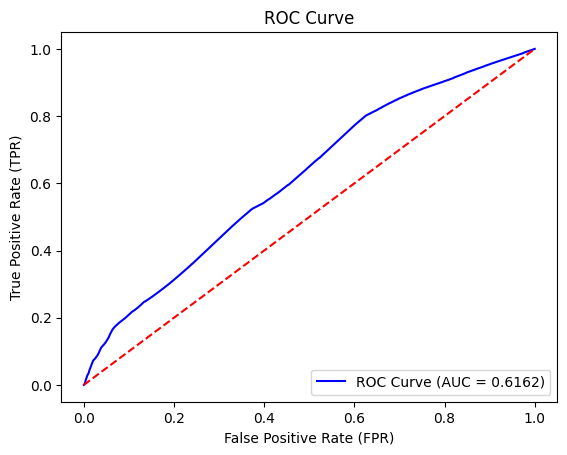

In [16]:
# ROC-AUC scores
roc_auc = roc_auc_score(y_val, y_val_probs)
print(f'ROC-AUC 점수: {roc_auc:.4f}')

# ROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # 랜덤 추측선
ax.set_xlabel('False Positive Rate (FPR)')  # 위양성 비율
ax.set_ylabel('True Positive Rate (TPR)')  # 진양성 비율
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
ax.grid(False)

# Predict(Validation)
# y_val_preds = random_search.best_estimator_.predict(X_val)

y_val_preds = model.predict(X_val)

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_preds)

<Axes: >

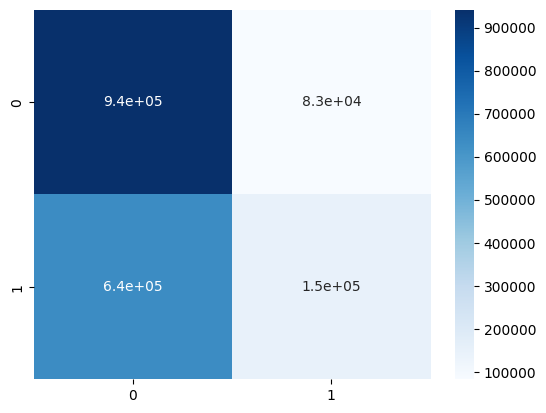

In [17]:
sns.heatmap(cm, annot=True, cmap='Blues')

In [18]:
test = pd.read_csv(f'../dataset/imbank_customer_data_2023.csv')

In [19]:
test['이탈여부'] = np.where(test['이탈여부'].isin(['이탈','위험','고위험']), 1, 0)

In [20]:
test.drop(['연령대', '기준년월', '고객ID', '고객등급','수신_외화예금', '대출금액', '총자산', '분기', '자산변화율'], axis= 1, inplace= True)

In [21]:
test.columns = ['sex', 'demand', 'fixed', 'savings', 'fund', '이탈여부','region', 'loan_status']

In [ ]:
# test_20 = test[test['연령대']=='20대'].drop(['연령대'], axis = 1)
# test_30 = test[test['연령대']=='30대'].drop(['연령대'], axis = 1)

In [ ]:
# test = test_20

In [22]:
# separate the target
y_test = test['이탈여부']  # target
X_test = test.drop('이탈여부', axis=1)

In [ ]:
# 20대, 30대 모델 따로 봐야...

ROC-AUC 점수: 0.6211


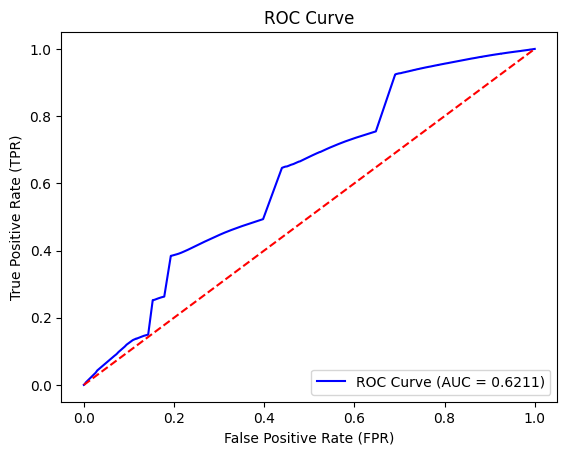

In [23]:
y_probs = model.predict_proba(X_test)[:, 1]

# ROC-AUC scores
roc_auc = roc_auc_score(y_test, y_probs)
print(f'ROC-AUC 점수: {roc_auc:.4f}')

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # 랜덤 추측선
ax.set_xlabel('False Positive Rate (FPR)')  # 위양성 비율
ax.set_ylabel('True Positive Rate (TPR)')  # 진양성 비율
ax.set_title('ROC Curve')
ax.legend(loc='lower right')
ax.grid(False)

# # Predict(Validation)
# y_val_preds = model.best_estimator_.predict(X_val)

y_preds = model.predict(X_test)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_preds)



<Axes: >

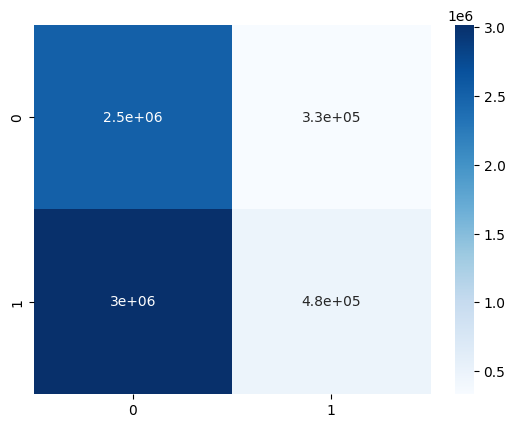

In [24]:
sns.heatmap(cm, annot=True, cmap='Blues')

In [25]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

r_score = recall_score(y_test, y_preds)
p_score = precision_score(y_test, y_preds)
score = accuracy_score(y_test, y_preds)

print(f"Recall: {r_score}, Precision: {p_score}, Accuracy: {score}")

Recall: 0.1374718184271434, Precision: 0.5932563693678817, Accuracy: 0.472548323542816


In [ ]:
#  # 2. 테스트 데이터에 대한 예측 확률 계산 
# y_pred_proba = logistic_pipeline.predict_proba(X)[:, 1]
# # 긍정 클래스(1)의 확률# 3. 임계값 0.4로 설정하여 예측값 분류 
# threshold = 0.42
# y_pred = (y_pred_proba >= threshold).astype(int)
# cm = confusion_matrix(y, y_pred)

<Axes: >

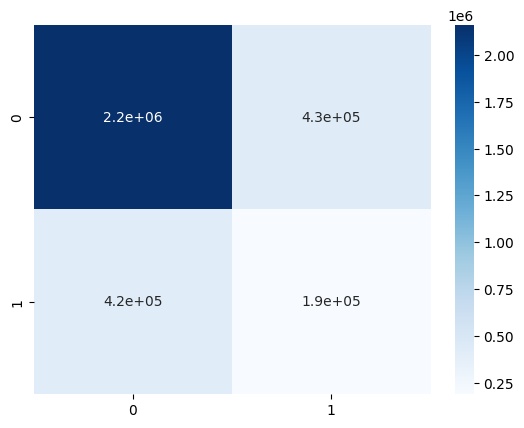

In [119]:
sns.heatmap(cm, annot=True, cmap='Blues')

In [34]:
train

,성별,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,이탈여부,지역구분,대출여부
0,여,1900000,5000000,11000000,0,0,1,0
1,남,5900000,0,0,0,1,1,1
4,남,400000,0,100000,0,1,1,0
6,남,7200000,0,0,0,0,1,0
9,남,1200000,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
6031435,남,100000,0,0,0,0,0,1
6031438,여,0,0,0,0,0,0,1
6031440,남,0,0,0,0,0,0,0
6031443,여,0,0,0,0,0,0,1


In [38]:
import statsmodels.formula.api as sm

sm.logit('이탈여부~성별+지역구분+대출여부+수신_요구불예금+수신_거치식예금+수신_적립식예금+수신_펀드', train).fit().summary()

Optimization terminated successfully.
         Current function value: 0.666551
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   이탈여부   No. Observations:              6033632
Model:                          Logit   Df Residuals:                  6033624
Method:                           MLE   Df Model:                            7
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                 0.02617
Time:                        14:00:05   Log-Likelihood:            -4.0217e+06
converged:                       True   LL-Null:                   -4.1298e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2373      0.003    -84.609      0.000      -0.243      -0.232
성별[T.여]        0.0320      0.002     19.033      0.000       0.029       0.035
지역구분          -0.0998      0.003    -36.756      0.000      -0.105      -0.094
대출여부           0.8978      0.003    341.124      0.000       0.893       0.903
수신_요구불예금    2.354e-09   1.17e-10     20.127      0.000    2.13e-09    2.58e-09
수신_거치식예금   -3.624e-09   1.53e-10    -23.744      0.000   -3.92e-09   -3.33e-09
수신_적립식예금   -7.198e-08   3.45e-10   -208.654      0.000   -7.27e-08   -7.13e-08
수신_펀드       1.338e-08   4.73e-10     28.253      0.000    1.24e-08    1.43e-08
==============================================================================
"""

In [ ]:
sm.logit('이탈여부 ~ 성별:지역구분 + 성별 + 지역구분 + 대출여부 + 수신_요구불예금 + 수신_거치식예금 + 수신_적립식예금 + 수신_펀드', train).fit().summary()

Optimization terminated successfully.
         Current function value: 0.666525
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   이탈여부   No. Observations:              6033632
Model:                          Logit   Df Residuals:                  6033623
Method:                           MLE   Df Model:                            8
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                 0.02621
Time:                        14:01:23   Log-Likelihood:            -4.0216e+06
converged:                       True   LL-Null:                   -4.1298e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1952      0.004    -53.318      0.000      -0.202      -0.188
성별[T.여]         -0.0512      0.005    -10.347      0.000      -0.061      -0.042
지역구분            -0.1472      0.004    -38.766      0.000      -0.155      -0.140
성별[T.여]:지역구분     0.0939      0.005     17.865      0.000       0.084       0.104
대출여부             0.8951      0.003    339.599      0.000       0.890       0.900
수신_요구불예금      2.373e-09   1.17e-10     20.288      0.000    2.14e-09     2.6e-09
수신_거치식예금     -3.646e-09   1.53e-10    -23.886      0.000   -3.95e-09   -3.35e-09
수신_적립식예금     -7.196e-08   3.45e-10   -208.624      0.000   -7.26e-08   -7.13e-08
수신_펀드         1.339e-08   4.73e-10     28.289      0.000    1.25e-08    1.43e-08
================================================================================
"""